<div style="border:2px solid black; padding: 10px; background-color: #f0f0f0; text-align: center;">
    <h1 style="color:red;">Projet 7: Implémentez un modèle de scoring</h1>
</div>

# <span style="color:brown;">Problématique</span>

Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser", qui propose des crédits à la consommation pour des personnes ayant peu ou pas d'historique de prêt. L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.).

## <span style="color:green;"> Objectif de la mission</span>


L'objectif principal de cette mission est de concevoir et de mettre en place un modèle de scoring crédit efficace. Ce modèle devra être capable de prédire avec précision la probabilité de remboursement des clients et de déterminer si une demande de crédit doit être acceptée ou refusée. Pour ce faire, il faudra exploiter différentes sources de données, incluant :

**Données comportementales** : Informations sur les habitudes de consommation et le comportement financier des clients.  
**Données externes**: Informations provenant d'autres institutions financières et sources de données publiques.

## <span style="color:green;"> Étapes clés de la mission </span>


<span style="color:brown; font-family: Helvetica; font-size: 120%;">Collecte et préparation des données :</span>
Rassembler les données internes et externes nécessaires.  
Effectuer un nettoyage et un prétraitement des données pour garantir leur qualité et leur pertinence.  

<span style="color:brown; font-family: Helvetica; font-size: 120%;">Exploration et analyse des données :</span>
Analyser les données pour identifier les tendances et les variables clés influençant le remboursement des crédits.  

<span style="color:brown; font-family: Helvetica; font-size: 120%;">Développement de l'algorithme de scoring :</span>
Sélectionner et implémenter des algorithmes de classification appropriés.  
Entraîner le modèle sur les données disponibles et ajuster ses paramètres pour optimiser les performances.  

<span style="color:brown; font-family: Helvetica; font-size: 120%;">Évaluation et validation du modèle :</span>
Évaluer les performances du modèle à l'aide de métriques appropriées (précision, rappel, F1-score, etc.).   
Effectuer une validation croisée pour assurer la robustesse du modèle.  

<span style="color:brown; font-family: Helvetica; font-size: 120%;">Mise en œuvre et suivi :</span>
Intégrer le modèle de scoring dans le processus de décision de crédit de l'entreprise.  
Mettre en place un système de suivi pour évaluer et améliorer continuellement les performances du modèle.

En réalisant cette mission, vous contribuerez à l'amélioration du processus de décision de crédit de "Prêt à dépenser", en permettant une évaluation plus précise des risques et une gestion plus efficace des demandes de crédit.

# <span style="color:brown;">Import des Bibliothèques</span>


In [61]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, fbeta_score

from sklearn.metrics import roc_auc_score, fbeta_score
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

import mlflow
import mlflow.sklearn

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import tempfile
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
from lime.lime_tabular import LimeTabularExplainer
import shap

# <span style="color:brown;">Import et Compréhension des données</span>

In [6]:
data1 = pd.read_csv("application_train.csv")
data2=pd.read_csv("application_test.csv")
data3=pd.read_csv("bureau_balance.csv")
data4=pd.read_csv("bureau.csv")
data5=pd.read_csv("HomeCredit_columns_description.csv",encoding='ISO-8859-1')
data6=pd.read_csv("installments_payments.csv")
data7=pd.read_csv("POS_CASH_balance.csv")
data8=pd.read_csv("previous_application.csv")
data9=pd.read_csv("sample_submission.csv")

## <span style="color:green;"> Feature enginnering et merge des données</span>

Ce code implémente un pipeline de traitement des données et de génération de caractéristiques pour un modèle de scoring de crédit. Il commence par définir plusieurs fonctions pour prétraiter différentes sources de données : les fichiers application_train.csv et application_test.csv contenant les données de demande de crédit, bureau.csv et bureau_balance.csv contenant les informations sur les crédits précédents, previous_application.csv détaillant les demandes de crédit antérieures, POS_CASH_balance.csv pour les soldes de crédit en espèces POS, installments_payments.csv pour les paiements par versements, et credit_card_balance.csv pour les soldes des cartes de crédit. Chaque fonction lit les fichiers CSV, effectue des opérations de nettoyage et d'encodage des données, et calcule des agrégations statistiques pour créer de nouvelles caractéristiques. Le pipeline principal, défini dans la fonction main, orchestre ces étapes en appelant successivement chaque fonction de prétraitement et en combinant les résultats dans un DataFrame final. Le contexte timer est utilisé pour mesurer et afficher le temps d'exécution de chaque étape du processus. Le pipeline peut être exécuté en mode débogage pour traiter un sous-ensemble de données, facilitant ainsi le développement et le test.

In [7]:
# Contexte de gestion du temps d'exécution pour mesurer le temps pris par chaque processus
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# Encodage one-hot pour les colonnes catégorielles avec get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Prétraitement des fichiers application_train.csv et application_test.csv
def application_train_test(num_rows=None, nan_as_category=False):
    # Lecture des données
    df = pd.read_csv('application_train.csv', nrows=num_rows)
    test_df = pd.read_csv('application_test.csv', nrows=num_rows)
    
    # Concaténation des données d'entraînement et de test
    df = pd.concat([df, test_df], axis=0, ignore_index=True)
    del test_df
    gc.collect()

    # Optionnel : Suppression des 4 applications avec CODE_GENDER XNA dans l'ensemble d'entraînement
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Encodage binaire pour les caractéristiques catégorielles
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], _ = pd.factorize(df[bin_feature])
    
    # Encodage one-hot pour les caractéristiques catégorielles
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # Valeurs NaN pour DAYS_EMPLOYED : 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    
    # Quelques nouvelles caractéristiques simples (pourcentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    
    return df

# Prétraitement des fichiers bureau.csv et bureau_balance.csv
def bureau_and_balance(num_rows=None, nan_as_category=True):
    bureau = pd.read_csv('bureau.csv', nrows=num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows=num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Agrégations pour bureau_balance et fusion avec bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace=True)
    del bb, bb_agg
    gc.collect()
    
    # Agrégations des caractéristiques numériques et catégorielles de bureau et bureau_balance
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    # Agrégations pour les crédits actifs
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    
    # Agrégations pour les crédits clôturés
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    
    return bureau_agg

# Prétraitement du fichier previous_applications.csv
def previous_applications(num_rows=None, nan_as_category=True):
    prev = pd.read_csv('previous_application.csv', nrows=num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)
    
    # Remplacer les valeurs de jours spécifiques par NaN
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)
    
    # Ajouter une caractéristique : pourcentage du montant demandé par rapport au montant reçu
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    
    # Agrégations des caractéristiques numériques des applications précédentes
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum']
    }
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    # Agrégations pour les applications approuvées
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    
    # Agrégations pour les applications refusées
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    
    return prev_agg

# Prétraitement du fichier POS_CASH_balance.csv
def pos_cash(num_rows=None, nan_as_category=True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows=num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)
    
    # Agrégations des caractéristiques
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    
    # Compter les comptes POS cash
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    
    return pos_agg

# Prétraitement du fichier installments_payments.csv
def installments_payments(num_rows=None, nan_as_category=True):
    ins = pd.read_csv('installments_payments.csv', nrows=num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)
    
    # Pourcentage et différence payée à chaque échéance (montant payé et valeur de l'échéance)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    
    # Jours de retard et jours avant échéance (pas de valeurs négatives)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    
    # Agrégations des caractéristiques
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    
    # Compter les comptes d'échéances
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    
    return ins_agg

# Prétraitement du fichier credit_card_balance.csv
def credit_card_balance(num_rows=None, nan_as_category=True):
    cc = pd.read_csv('credit_card_balance.csv', nrows=num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)
    
    # Agrégations générales
    cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    
    # Compter les lignes de cartes de crédit
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    
    return cc_agg

# LightGBM GBDT avec KFold ou Stratified KFold
# Paramètres de Tilii kernel : https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code

def main(debug=False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    
    return df

if __name__ == "__main__":
    # Nom du fichier de soumission
    with timer("Full model run"):
        df = main()


Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 15s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 21s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 10s
Installments payments df shape: (339587, 26)
Process installments payments - done in 24s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 13s
Full model run - done in 87s


In [8]:
df.shape

(356251, 797)

In [11]:
df.columns

Index(['SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'CC_NAME_CONTRACT_STATUS_Signed_MAX',
       'CC_NAME_CONTRACT_STATUS_Signed_MEAN',
       'CC_NAME_CONTRACT_STATUS_Signed_SUM',
       'CC_NAME_CONTRACT_STATUS_Signed_VAR', 'CC_NAME_CONTRACT_STATUS_nan_MIN',
       'CC_NAME_CONTRACT_STATUS_nan_MAX', 'CC_NAME_CONTRACT_STATUS_nan_MEAN',
       'CC_NAME_CONTRACT_STATUS_nan_SUM', 'CC_NAME_CONTRACT_STATUS_nan_VAR',
       'CC_COUNT'],
      dtype='object', length=797)

In [12]:
df.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,False,0.0,0.0,0.0,False,False,0.0,0.0,0.0,6.0
4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [265]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356251 entries, 0 to 356254
Columns: 797 entries, SK_ID_CURR to CC_COUNT
dtypes: bool(133), float64(606), int64(42), object(16)
memory usage: 1.8+ GB


## <span style="color:green;"> Explication des principales colonnes </span>

Pour bien comprendre nos données et identifier clairement notre variable cible, nous présentons ci-dessous un tableau récapitulatif des différentes colonnes du DataFrame ainsi que leurs explications. Ce tableau nous permettra de mieux appréhender les informations disponibles et d'identifier les variables clés qui seront utilisées dans notre analyse et notre modèle de scoring de crédit. La colonne TARGET est particulièrement importante car elle indique si un client a fait défaut sur le prêt (1 = défaut, 0 = non défaut).

| Colonne                     | Explication                                                                                  |
|-----------------------------|----------------------------------------------------------------------------------------------|
| SK_ID_CURR                  | Identifiant unique pour chaque client dans le jeu de données.                                 |
| TARGET                      | Variable cible indiquant si le client a fait défaut sur le prêt (1 = défaut, 0 = non défaut). |
| CODE_GENDER                 | Code représentant le genre du client (0 = féminin, 1 = masculin, par exemple).                |
| FLAG_OWN_CAR                | Indicateur binaire indiquant si le client possède une voiture (1 = oui, 0 = non).            |
| FLAG_OWN_REALTY             | Indicateur binaire indiquant si le client possède une propriété (1 = oui, 0 = non).          |
| CNT_CHILDREN                | Nombre d'enfants à charge du client.                                                          |
| AMT_INCOME_TOTAL            | Revenu total annuel du client.                                                                |
| AMT_CREDIT                  | Montant total du crédit demandé par le client.                                                |
| AMT_ANNUITY                 | Montant annuel de l'annuité que le client doit payer pour le crédit.                          |
| NAME_CONTRACT_TYPE          | Type de contrat de prêt (Cash loans, Revolving loans).                                        |
| FLAG_MOBIL                  | Indicateur de possession de téléphone mobile.                                                 |
| FLAG_EMP_PHONE              | Indicateur si le client a un téléphone professionnel.                                         |
| FLAG_WORK_PHONE             | Indicateur si le client a un téléphone au travail.                                            |
| FLAG_CONT_MOBILE            | Indicateur si le client a un mobile à contact permanent.                                      |
| FLAG_PHONE                  | Indicateur si le client a un téléphone fixe.                                                  |
| FLAG_EMAIL                  | Indicateur si le client a un email.                                                           |
| OCCUPATION_TYPE             | Type de profession du client.                                                                 |
| CNT_FAM_MEMBERS             | Nombre de membres dans la famille du client.                                                  |
| REGION_RATING_CLIENT        | Note de la région où vit le client.                                                           |
| WEEKDAY_APPR_PROCESS_START  | Jour de la semaine où la demande de prêt a été initiée.                                       |
| HOUR_APPR_PROCESS_START     | Heure de la journée où la demande de prêt a été initiée.                                      |
| ORGANIZATION_TYPE           | Type d'organisation où le client travaille.                                                   |
| EXT_SOURCE_1                | Score externe de la source 1.                                                                 |
| EXT_SOURCE_2                | Score externe de la source 2.                                                                 |
| EXT_SOURCE_3                | Score externe de la source 3.                                                                 |
| APARTMENTS_AVG              | Moyenne des valeurs pour les appartements associés au client.                                 |
| BASEMENTAREA_AVG            | Moyenne des valeurs pour les sous-sols associés au client.                                    |
| YEARS_BEGINEXPLUATATION_AVG | Moyenne des valeurs pour les années depuis le début de l'exploitation des propriétés associées au client. |
| YEARS_BUILD_AVG             | Moyenne des valeurs pour les années de construction des propriétés associées au client.       |
| COMMONAREA_AVG              | Moyenne des valeurs pour les espaces communs associés au client.                              |
| ELEVATORS_AVG               | Moyenne des valeurs pour les ascenseurs associés au client.                                   |
| ENTRANCES_AVG               | Moyenne des valeurs pour les entrées des propriétés associées au client.                      |
| FLOORSMAX_AVG               | Moyenne des valeurs pour les étages maximaux des propriétés associées au client.              |
| FLOORSMIN_AVG               | Moyenne des valeurs pour les étages minimaux des propriétés associées au client.              |
| LANDAREA_AVG                | Moyenne des valeurs pour les surfaces de terrain associées au client.                         |
| LIVINGAPARTMENTS_AVG        | Moyenne des valeurs pour les appartements habitables associés au client.                      |
| LIVINGAREA_AVG              | Moyenne des valeurs pour les surfaces habitables associées au client.                         |
| NONLIVINGAPARTMENTS_AVG     | Moyenne des valeurs pour les appartements non habitables associés au client.                  |
| NONLIVINGAREA_AVG           | Moyenne des valeurs pour les surfaces non habitables associées au client.                     |
| APARTMENTS_MODE             | Mode des valeurs pour les appartements associés au client.                                    |
| BASEMENTAREA_MODE           | Mode des valeurs pour les sous-sols associés au client.                                       |
| YEARS_BEGINEXPLUATATION_MODE| Mode des valeurs pour les années depuis le début de l'exploitation des propriétés associées au client. |
| YEARS_BUILD_MODE            | Mode des valeurs pour les années de construction des propriétés associées au client.          |
| COMMONAREA_MODE             | Mode des valeurs pour les espaces communs associés au client.                                 |
| ELEVATORS_MODE              | Mode des valeurs pour les ascenseurs associés au client.                                      |
| ENTRANCES_MODE              | Mode des valeurs pour les entrées des propriétés associées au client.                         |
| FLOORSMAX_MODE              | Mode des valeurs pour les étages maximaux des propriétés associées au client.                 |
| FLOORSMIN_MODE              | Mode des valeurs pour les étages minimaux des propriétés associées au client.                 |
| LANDAREA_MODE               | Mode des valeurs pour les surfaces de terrain associées au client.                            |
| LIVINGAPARTMENTS_MODE       | Mode des valeurs pour les appartements habitables associés au client.                         |
| LIVINGAREA_MODE             | Mode des valeurs pour les surfaces habitables associées au client.                            |
| NONLIVINGAPARTMENTS_MODE    | Mode des valeurs pour les appartements non habitables associés au client.                     |
| NONLIVINGAREA_MODE          | Mode des valeurs pour les surfaces non habitables associées au client.                        |
| APARTMENTS_MEDI             | Médiane des valeurs pour les appartements associés au client.                                 |
| BASEMENTAREA_MEDI           | Médiane des valeurs pour les sous-sols associés au client.                                    |
| YEARS_BEGINEXPLUATATION_MEDI| Médiane des valeurs pour les années depuis le début de l'exploitation des propriétés associées au client. |
| YEARS_BUILD_MEDI            | Médiane des valeurs pour les années de construction des propriétés associées au client.       |
| COMMONAREA_MEDI             | Médiane des valeurs pour les espaces communs associés au client.                              |
| ELEVATORS_MEDI              | Médiane des valeurs pour les ascenseurs associés au client.                                   |
| ENTRANCES_MEDI              | Médiane des valeurs pour les entrées des propriétés associées au client.                      |
| FLOORSMAX_MEDI              | Médiane des valeurs pour les étages maximaux des propriétés associées au client.              |
| FLOORSMIN_MEDI              | Médiane des valeurs pour les étages minimaux des propriétés associées au client.              |
| LANDAREA_MEDI               | Médiane des valeurs pour les surfaces de terrain associées au client.                         |
| LIVINGAPARTMENTS_MEDI       | Médiane des valeurs pour les appartements habitables associés au client.                      |
| LIVINGAREA_MEDI             | Médiane des valeurs pour les surfaces habitables associées au client.                         |
| NONLIVINGAPARTMENTS_MEDI    | Médiane des valeurs pour les appartements non habitables associés au client.                  |
| NONLIVINGAREA_MEDI          | Médiane des valeurs pour les surfaces non habitables associées au client.                     |
| FONDKAPREMONT_MODE          | Mode des fonds de réparation associés au client.                                              |
| HOUSETYPE_MODE              | Mode des types de maison associés au client.                                                  |
| TOTALAREA_MODE              | Mode des surfaces totales associées au client.                                                |
| WALLSMATERIAL_MODE          | Mode des matériaux des murs des propriétés associées au client.                               |
| EMERGENCYSTATE_MODE         | Mode des états d'urgence associés au client.                                                  |


Étant donné que la base de données est très volumineuse, nous allons en prendre un échantillon.

In [28]:
sampled_df = df.sample(frac=0.3, random_state=42)

In [29]:
sampled_df.head()

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
24226,128180,0.0,1,0,0,0,90000.0,562491.0,27189.0,454500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
329012,255978,NaN,1,0,0,0,157500.0,225000.0,17905.5,225000.0,...,False,0.0,0.0,0.000000,False,False,0.0,0.0,0.0,96.0
205320,337998,0.0,1,0,0,0,157500.0,333621.0,16177.5,288000.0,...,False,0.0,0.0,0.000000,False,False,0.0,0.0,0.0,11.0
162013,287819,0.0,1,1,1,0,36607.5,275040.0,10498.5,180000.0,...,True,0.1,4.0,0.092308,False,False,0.0,0.0,0.0,40.0
71833,183296,0.0,1,0,1,0,67500.0,182016.0,14508.0,144000.0,...,False,0.0,0.0,0.000000,False,False,0.0,0.0,0.0,6.0


## <span style="color:green;"> sélection des caractéristiques</span>

### Corrélation

Nous avons choisi de sélectionner les 50 caractéristiques les plus corrélées avec la variable cible **Target** pour notre modèle de machine learning afin d'optimiser les performances. Cette sélection permet de réduire la dimensionnalité du jeu de données, éliminant ainsi les caractéristiques redondantes ou non informatives qui pourraient introduire du bruit et compliquer le modèle. En nous concentrant sur les caractéristiques les plus pertinentes, nous améliorons la précision des prédictions tout en diminuant le risque de surapprentissage. De plus, ce choix rend le modèle plus efficace computationnellement et plus facile à interpréter, facilitant ainsi sa mise en œuvre et son analyse.

In [30]:
# Calculer les corrélations avec la colonne cible
target_column = "TARGET"
correlations = sampled_df.corr()[target_column].drop(target_column)

# Sélectionner les 50 colonnes les plus corrélées
top_50_corr_columns = correlations.abs().nlargest(50).index

# Ajouter la colonne cible et les colonnes les plus corrélées à la liste des colonnes sélectionnées
selected_columns = [target_column] + list(top_50_corr_columns) + ['SK_ID_CURR']

# Créer le DataFrame final avec les colonnes sélectionnées
selected_data = df[selected_columns]

# Afficher les premières lignes des données sélectionnées
selected_data.head()

   TARGET  EXT_SOURCE_3  EXT_SOURCE_2  EXT_SOURCE_1  \
0     1.0      0.139376      0.262949      0.083037   
1     0.0           NaN      0.622246      0.311267   
2     0.0      0.729567      0.555912           NaN   
3     0.0           NaN      0.650442           NaN   
4     0.0           NaN      0.322738           NaN   

   CC_CNT_DRAWINGS_ATM_CURRENT_MEAN  CC_CNT_DRAWINGS_CURRENT_MAX  \
0                               NaN                          NaN   
1                               NaN                          NaN   
2                               NaN                          NaN   
3                               NaN                          0.0   
4                               NaN                          NaN   

   CC_CNT_DRAWINGS_CURRENT_MEAN  BURO_DAYS_CREDIT_MEAN  CC_AMT_BALANCE_MEAN  \
0                           NaN                -874.00                  NaN   
1                           NaN               -1400.75                  NaN   
2                      

In [31]:
selected_data.head()

,TARGET,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_MAX,CC_CNT_DRAWINGS_CURRENT_MEAN,BURO_DAYS_CREDIT_MEAN,CC_AMT_BALANCE_MEAN,CC_AMT_TOTAL_RECEIVABLE_MEAN,...,REFUSED_DAYS_DECISION_MEAN,CLOSED_DAYS_CREDIT_MIN,CC_NAME_CONTRACT_STATUS_Active_SUM,ACTIVE_MONTHS_BALANCE_SIZE_MEAN,CC_MONTHS_BALANCE_SUM,CC_MONTHS_BALANCE_VAR,ACTIVE_DAYS_CREDIT_MEAN,CC_AMT_INST_MIN_REGULARITY_MAX,CC_CNT_DRAWINGS_ATM_CURRENT_MAX,SK_ID_CURR
0,1.0,0.139376,0.262949,0.083037,NaN,NaN,NaN,-874.00,NaN,NaN,...,NaN,-1437.0,NaN,10.0,NaN,NaN,-572.5,NaN,NaN,100002
1,0.0,NaN,0.622246,0.311267,NaN,NaN,NaN,-1400.75,NaN,NaN,...,NaN,-2586.0,NaN,NaN,NaN,NaN,-606.0,NaN,NaN,100003
2,0.0,0.729567,0.555912,NaN,NaN,NaN,NaN,-867.00,NaN,NaN,...,NaN,-1326.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100004
3,0.0,NaN,0.650442,NaN,NaN,0.0,0.0,NaN,0.0,0.0,...,-181.0,NaN,6.0,NaN,-21.0,3.5,NaN,0.0,NaN,100006
4,0.0,NaN,0.322738,NaN,NaN,NaN,NaN,-1149.00,NaN,NaN,...,NaN,-1149.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100007


## <span style="color:green;">Traitement des données</span>

### Imputation des valeurs manquantes

In [32]:
from sklearn.impute import SimpleImputer
colonnes_numeriques = selected_data.select_dtypes(include=['number']).drop(columns=['TARGET'])

# Initialiser un SimpleImputer avec la stratégie de remplacement des valeurs manquantes par la moyenne
imputer = SimpleImputer(strategy='mean')

# Adapter l'imputer aux données numériques
imputer.fit(colonnes_numeriques)

# Remplacer les valeurs manquantes dans les colonnes numériques avec la moyenne calculée
selected_data[colonnes_numeriques.columns] = imputer.transform(colonnes_numeriques)

C:\Users\kaout\AppData\Local\Temp\ipykernel_18556\101933867.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_data[colonnes_numeriques.columns] = imputer.transform(colonnes_numeriques)


In [33]:
selected_data.isnull().sum()

TARGET                                     48744
EXT_SOURCE_3                                   0
EXT_SOURCE_2                                   0
EXT_SOURCE_1                                   0
CC_CNT_DRAWINGS_ATM_CURRENT_MEAN               0
CC_CNT_DRAWINGS_CURRENT_MAX                    0
CC_CNT_DRAWINGS_CURRENT_MEAN                   0
BURO_DAYS_CREDIT_MEAN                          0
CC_AMT_BALANCE_MEAN                            0
CC_AMT_TOTAL_RECEIVABLE_MEAN                   0
CC_AMT_RECIVABLE_MEAN                          0
CC_AMT_RECEIVABLE_PRINCIPAL_MEAN               0
DAYS_BIRTH                                     0
PREV_NAME_CONTRACT_STATUS_Refused_MEAN         0
BURO_CREDIT_ACTIVE_Closed_MEAN                 0
DAYS_EMPLOYED                                  0
BURO_CREDIT_ACTIVE_Active_MEAN                 0
PREV_CODE_REJECT_REASON_XAP_MEAN               0
BURO_DAYS_CREDIT_MIN                           0
BURO_MONTHS_BALANCE_MIN_MIN                    0
CC_AMT_INST_MIN_REGU

### Supression des valeurs manquantes[Target]

In [34]:
selected_data = selected_data.dropna(subset=['TARGET'])

### Feature selection

Afin d'améliorer l'efficacité et la performance de notre modèle de machine learning, nous allons effectuer une sélection des features. Cette étape consiste à identifier et retenir les caractéristiques les plus pertinentes et influentes pour la prédiction de la variable cible, tout en éliminant les features moins significatives. Nous utiliserons la méthode SelectKBest avec la fonction de score f_classif pour sélectionner les 20 meilleures features basées sur leur relation statistique avec la cible. Cette approche nous permet de réduire la dimensionnalité des données, de minimiser le surapprentissage et d'accélérer le temps de calcul, tout en conservant la colonne SK_ID_CURR pour un suivi unique des enregistrements.

In [35]:
df1=selected_data.copy()

In [37]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif

# Assurez-vous que 'df1' contient les colonnes 'TARGET' et 'SK_ID_CURR'

# Séparation des features et de la cible
X = df1.drop(columns=['TARGET', 'SK_ID_CURR'])
y = df1['TARGET']

# Sélection des 20 meilleures features
k_best_selector = SelectKBest(score_func=f_classif, k=20)
X_new = k_best_selector.fit_transform(X, y)
selected_feature_indices = k_best_selector.get_support(indices=True)

# Récupération des noms des features sélectionnées
selected_features = list(X.columns[selected_feature_indices]) + ['TARGET', 'SK_ID_CURR']

# Création du DataFrame final avec les features sélectionnées, la cible et SK_ID_CURR
final_selected_data = df1[selected_features]

# Affichage des premières lignes des données sélectionnées
final_selected_data.head()

,EXT_SOURCE_3,EXT_SOURCE_2,EXT_SOURCE_1,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_MAX,BURO_DAYS_CREDIT_MEAN,CC_AMT_BALANCE_MEAN,CC_AMT_TOTAL_RECEIVABLE_MEAN,DAYS_BIRTH,PREV_NAME_CONTRACT_STATUS_Refused_MEAN,...,BURO_CREDIT_ACTIVE_Active_MEAN,PREV_CODE_REJECT_REASON_XAP_MEAN,BURO_DAYS_CREDIT_MIN,BURO_DAYS_CREDIT_UPDATE_MEAN,DAYS_EMPLOYED_PERC,PREV_NAME_CONTRACT_STATUS_Approved_MEAN,CLOSED_DAYS_CREDIT_MIN,ACTIVE_DAYS_CREDIT_MEAN,TARGET,SK_ID_CURR
0,0.139376,0.262949,0.083037,0.546925,6.748354,-874.000000,69973.192455,69509.320208,-9461.0,0.000000,...,0.250000,1.000000,-1437.000000,-499.875000,0.067329,1.000000,-1437.000000,-572.500000,1.0,100002.0
1,0.509353,0.622246,0.311267,0.546925,6.748354,-1400.750000,69973.192455,69509.320208,-16765.0,0.000000,...,0.250000,1.000000,-2586.000000,-816.000000,0.070862,1.000000,-2586.000000,-606.000000,0.0,100003.0
2,0.729567,0.555912,0.501964,0.546925,6.748354,-867.000000,69973.192455,69509.320208,-19046.0,0.000000,...,0.000000,1.000000,-1326.000000,-532.000000,0.011814,1.000000,-1326.000000,-653.289037,0.0,100004.0
3,0.509353,0.650442,0.501964,0.546925,0.000000,-1083.804525,0.000000,0.000000,-19005.0,0.111111,...,0.410223,0.888889,-1764.360989,-542.967626,0.159905,0.555556,-1873.685583,-653.289037,0.0,100006.0
4,0.509353,0.322738,0.501964,0.546925,6.748354,-1149.000000,69973.192455,69509.320208,-19932.0,0.000000,...,0.000000,1.000000,-1149.000000,-783.000000,0.152418,1.000000,-1149.000000,-653.289037,0.0,100007.0


In [266]:
final_selected_data.shape

(307507, 22)

# <span style="color:brown;">prédiction</span>

## <span style="color:green;">Train test split </span>

In [267]:
sampled_df1 = final_selected_data.sample(n=10000, random_state=42)

In [268]:
sampled_df1.to_csv('sampled_df1.csv', index=False)

In [269]:
X = sampled_df1.drop(columns=['TARGET', 'SK_ID_CURR'])
y = sampled_df1['TARGET']

In [270]:
# Sépration en jeu d'entrainement / jeu de validation, 80% des données pour l'entraînement
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

# vérification de la taille des matrices :
X_train.shape, X_test.shape

((8000, 20), (2000, 20))

## <span style="color:green;">DummyClassifier </span>

In [271]:
# Création du Dummy Classifier
dummy_clf = DummyClassifier(strategy="most_frequent")

# Entraînement du Dummy Classifier
dummy_clf.fit(X_train, y_train)

# Prédiction avec le Dummy Classifier
y_pred = dummy_clf.predict(X_test)

# Calcul des scores
accuracy = accuracy_score(y_test, y_pred)
fbeta = fbeta_score(y_test, y_pred, beta=10)
auc = roc_auc_score(y_test, y_pred)

# Afficher les résultats dans un tableau
results = {
    'Metric': ['Accuracy', 'F-beta score (beta=10)', 'AUC score'],
    'Score': [accuracy, fbeta, auc]
}

results_df = pd.DataFrame(results)
print(results_df)

                   Metric  Score
0                Accuracy  0.926
1  F-beta score (beta=10)  0.000
2               AUC score  0.500


Le Dummy Classifier sert de référence minimale. Les scores montrent qu'il ne capture pas la classe minoritaire et n'a aucune capacité prédictive réelle.

## <span style="color:green;">Fonctions </span>

In [272]:
# Mlflow
import mlflow
import mlflow.sklearn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def log_results_to_mlflow(model_name, best_model, best_params, X_train, X_test, y_train, y_test):
    with mlflow.start_run(run_name=model_name):
        y_train_pred = best_model.predict(X_train)
        y_test_pred = best_model.predict(X_test)

        roc_auc_train = roc_auc_score(y_train, y_train_pred)
        roc_auc_test = roc_auc_score(y_test, y_test_pred)
        fbeta_train = fbeta_score(y_train, y_train_pred, beta=10, average='macro')
        fbeta_test = fbeta_score(y_test, y_test_pred, beta=10, average='macro')

        mlflow.log_params(best_params)
        mlflow.log_metric("roc_auc_train", roc_auc_train)
        mlflow.log_metric("roc_auc_test", roc_auc_test)
        mlflow.log_metric("fbeta_train", fbeta_train)
        mlflow.log_metric("fbeta_test", fbeta_test)
        mlflow.sklearn.log_model(best_model, model_name)
        
        # Plot and log confusion matrix
        cm = confusion_matrix(y_test, y_test_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'], linewidths=.5, linecolor='black')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title(f'Matrice de Confusion - {model_name}')
        plt.savefig(f"confusion_matrix_{model_name}.png")
        mlflow.log_artifact(f"confusion_matrix_{model_name}.png")
        plt.close()

In [273]:
#Modélisation
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import uniform, loguniform
from sklearn.metrics import fbeta_score, roc_auc_score, make_scorer, confusion_matrix, roc_curve, auc

def create_pipeline(model):
    return ImbPipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE()),
        ('classifier', model)
    ])

def perform_random_search(pipeline, param_dist, X_train, y_train, scoring, cv=5, n_iter=50):
    random_search = RandomizedSearchCV(estimator=pipeline, 
                                       param_distributions=param_dist,
                                       scoring=scoring,
                                       refit=True,                              
                                       cv=cv,
                                       n_jobs=-1,
                                       verbose=1,
                                       n_iter=n_iter,
                                       random_state=42)
    random_search.fit(X_train, y_train)
    return random_search.best_params_, random_search.best_estimator_, random_search.best_score_

def evaluate_model(model, X_train, y_train, X_test, y_test, fbeta_cv, roc_auc_cv, beta=10):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    fbeta_train = fbeta_score(y_train, y_train_pred, beta=beta, average='macro')
    fbeta_test = fbeta_score(y_test, y_test_pred, beta=beta, average='macro')
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    
    return {
        'F-beta (train)': fbeta_train,
        'F-beta (test)': fbeta_test,
        'ROC AUC (train)': roc_auc_train,
        'ROC AUC (test)': roc_auc_test,
        'F-beta (cross-validation)': fbeta_cv,
        'ROC AUC (cross-validation)': roc_auc_cv
    }

def plot_confusion_matrix_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=['Negative', 'Positive'], cmap=plt.cm.Blues)
    disp.ax_.set_title(f'Matrice de Confusion - {model_name}')
    plt.show()

def plot_roc_auc_model(model, X_test, y_test, model_name):
    y_score = model.decision_function(X_test) if hasattr(model, "decision_function") else model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC-AUC - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

def collect_results(model_name, model, param_dist, X_train, y_train, X_test, y_test):
    # Recherche aléatoire pour F-beta
    fbeta_scorer = make_scorer(fbeta_score, beta=10, average='macro')
    roc_auc_scorer = 'roc_auc'

    # Perform random search for F-beta
    grid_search_fbeta = RandomizedSearchCV(estimator=model, 
                                           param_distributions=param_dist,
                                           scoring=fbeta_scorer,
                                           refit=True,                              
                                           cv=5,
                                           n_jobs=-1,
                                           verbose=1,
                                           n_iter=50,
                                           random_state=42)
    grid_search_fbeta.fit(X_train, y_train)
    best_model_fbeta = grid_search_fbeta.best_estimator_
    best_params_fbeta = grid_search_fbeta.best_params_
    fbeta_cv = grid_search_fbeta.best_score_

    # Perform random search for ROC AUC
    grid_search_roc_auc = RandomizedSearchCV(estimator=model, 
                                             param_distributions=param_dist,
                                             scoring=roc_auc_scorer,
                                             refit=True,                              
                                             cv=5,
                                             n_jobs=-1,
                                             verbose=1,
                                             n_iter=50,
                                             random_state=42)
    grid_search_roc_auc.fit(X_train, y_train)
    best_model_roc_auc = grid_search_roc_auc.best_estimator_
    best_params_roc_auc = grid_search_roc_auc.best_params_
    roc_auc_cv = grid_search_roc_auc.best_score_

    # Evaluate model
    results = evaluate_model(best_model_fbeta, X_train, y_train, X_test, y_test, fbeta_cv, roc_auc_cv)
    results['Model'] = model_name
    results['Best Params'] = best_params_fbeta

    # Log results to MLflow
    log_results_to_mlflow(f"{model_name}_Fbeta", best_model_fbeta, best_params_fbeta, X_train, X_test, y_train, y_test)
    log_results_to_mlflow(f"{model_name}_ROC_AUC", best_model_roc_auc, best_params_roc_auc, X_train, X_test, y_train, y_test)

    return best_model_fbeta, results


In [274]:
results_list = []

## <span style="color:green;">LogisticRegression </span>

In [275]:
lr_pipeline = create_pipeline(LogisticRegression())
lr_param_dist = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': loguniform(1e-4, 1e1),  
    'classifier__max_iter': [10,20],  
    'classifier__solver': ['liblinear'],
    'classifier__tol': loguniform(1e-3, 5e-3)
}

lr_model, lr_results = collect_results("Logistic Regression", lr_pipeline, lr_param_dist, X_train, y_train, X_test, y_test)
results_list.append(lr_results)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\kaout\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 5 folds for each of 50 candidates, totalling 250 fits


###  Matrice de confusion et courbe Roc-AUC Lr

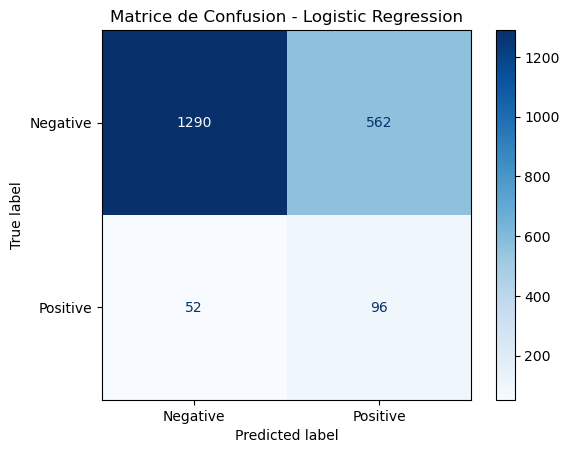

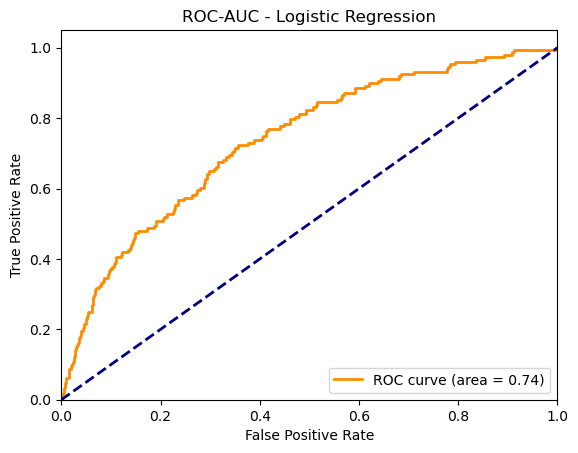

In [276]:
plot_confusion_matrix_model(lr_model, X_test, y_test, "Logistic Regression")
plot_roc_auc_model(lr_model, X_test, y_test, "Logistic Regression")

## <span style="color:green;">Support Vector Classifier (SVC) </span>

In [277]:
svc_pipeline = create_pipeline(SVC())
svc_param_dist = {
    'classifier__C': [1.0, 10.0],
    'classifier__kernel': ['linear']
}

svc_model, svc_results = collect_results("SVC", svc_pipeline, svc_param_dist, X_train, y_train, X_test, y_test)
results_list.append(svc_results)

C:\Users\kaout\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 2 is smaller than n_iter=50. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 2 candidates, totalling 10 fits


C:\Users\kaout\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 2 is smaller than n_iter=50. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 2 candidates, totalling 10 fits


###  Matrice de confusion et courbe Roc-AUC SVC

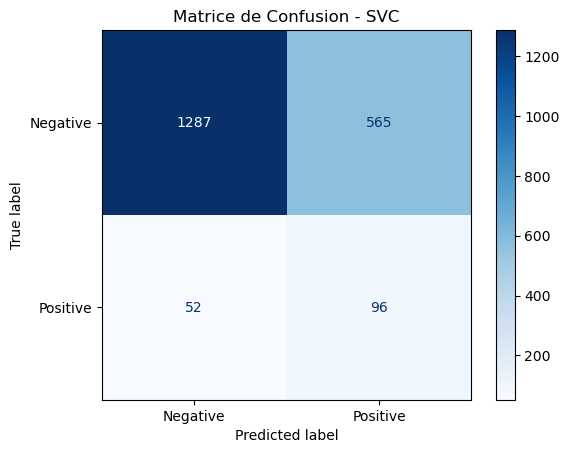

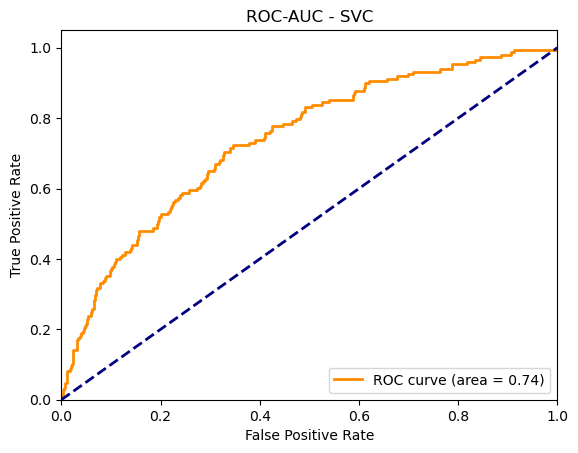

In [278]:
plot_confusion_matrix_model(svc_model, X_test, y_test, "SVC")
plot_roc_auc_model(svc_model, X_test, y_test, "SVC")

## <span style="color:green;">Gradient Boosting Classifier </span>

In [279]:
from scipy.stats import uniform, randint
gb_pipeline = create_pipeline(GradientBoostingClassifier())
gb_param_dist = {
    'classifier__learning_rate': uniform(0.0001, 0.1),  
    'classifier__max_depth': randint(1, 5),  
    'classifier__n_estimators': randint(50, 301),  
    'classifier__min_samples_split': randint(2, 101), 
    'classifier__min_samples_leaf': randint(1, 41),  
    'classifier__subsample': uniform(0.5, 0.5)  
}
gb_model, gb_results = collect_results("Gradient Boosting", gb_pipeline, gb_param_dist, X_train, y_train, X_test, y_test)
results_list.append(gb_results)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits


###  Matrice de confusion et courbe Roc-AUC Gradient Boosting Classifier

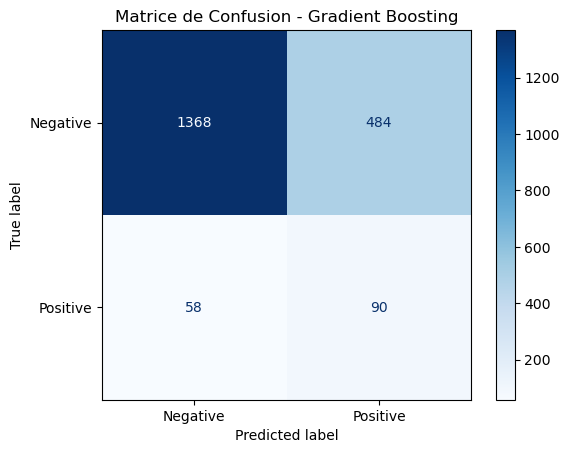

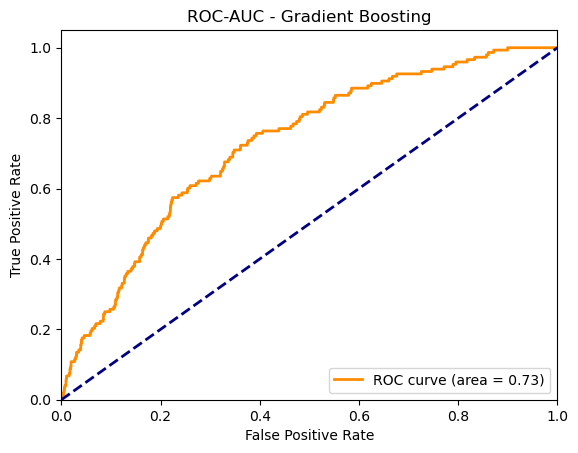

In [280]:
plot_confusion_matrix_model(gb_model, X_test, y_test, "Gradient Boosting")
plot_roc_auc_model(gb_model, X_test, y_test, "Gradient Boosting")

## <span style="color:green;">Comparaison des différents modeles </span>

In [281]:
print("Tous les résultats des modèles :")
results_df = pd.DataFrame(results_list)
results_df

Tous les résultats des modèles :


,F-beta (train),F-beta (test),ROC AUC (train),ROC AUC (test),F-beta (cross-validation),ROC AUC (cross-validation),Model,Best Params
0,0.676367,0.662848,0.685176,0.672596,0.674904,0.736434,Logistic Regression,"{'classifier__C': 1.230477933008369, 'classifi..."
1,0.675421,0.661981,0.684216,0.671787,0.669426,0.734063,SVC,"{'classifier__kernel': 'linear', 'classifier__..."
2,0.683419,0.665802,0.690444,0.673385,0.659149,0.720698,Gradient Boosting,{'classifier__learning_rate': 0.01626287140946...


**On continue avec GradientboostingClassifier pour le reste du projet**

In [282]:
!mlflow ui

^C


In [200]:
import subprocess
subprocess.Popen(["mlflow", "ui", "--port", "5001"])

<Popen: returncode: None args: ['mlflow', 'ui', '--port', '5001']>

# <span style="color:brown;">courbe du seuil en fonction du F-beta scorel</span>

Pour définir un score métier qui pénalise fortement les faux négatifs, on peut utiliser une version personnalisée du F-beta score où le paramètre β est ajusté pour mettre davantage l'accent sur la précision ou le rappel. Dans notre cas, on veux pénaliser fortement les faux négatifs, donc on peut utiliser un F-beta score avec une valeur élevée par exemple β=10.

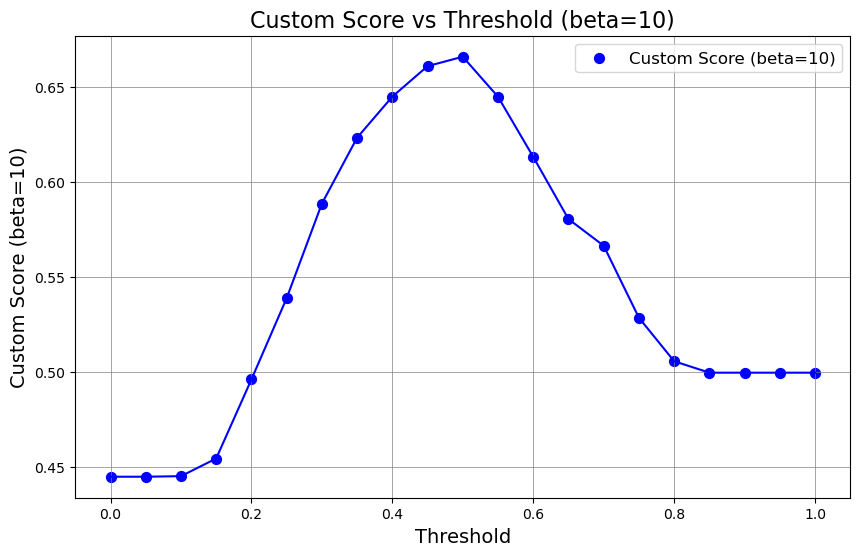

In [283]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import fbeta_score

def calculate_custom_scores(y_true, y_proba, beta=10, thresholds=np.arange(0.0, 1.05, 0.05)):
    scores = []
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        score = fbeta_score(y_true, y_pred, beta=beta, average='macro')
        scores.append(score)
    return scores

def plot_custom_threshold_curve(y_true, y_proba, beta=10):
    thresholds = np.arange(0.0, 1.05, 0.05)
    custom_scores = calculate_custom_scores(y_true, y_proba, beta, thresholds)
    
    plt.style.use('default')  
    plt.figure(figsize=(10, 6))
    plt.scatter(thresholds, custom_scores, color='blue', label=f'Custom Score (beta={beta})', s=50) 
    plt.plot(thresholds, custom_scores, color='blue')
    plt.xlabel('Threshold', fontsize=14)
    plt.ylabel(f'Custom Score (beta={beta})', fontsize=14)
    plt.title(f'Custom Score vs Threshold (beta={beta})', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True, color='gray', linestyle='-', linewidth=0.5)
    plt.show()


y_test_proba_gb = gb_model.predict_proba(X_test)[:, 1]  # Probabilités pour la classe positive

plot_custom_threshold_curve(y_test, y_test_proba_gb, beta=10)


la courbe montre clairement l'impact des différents seuils sur le F-beta score avec une forte pénalisation des faux négatifs (beta=10). Le pic autour de 0.45 indique le seuil optimal pour maximiser ce score. En utilisant cette courbe, on peut prendre des décisions éclairées sur le choix du seuil pour le modèle, en fonction de l'importance relative des faux négatifs dans notre contexte métier.

# <span style="color:brown;">Feature importance globale et Local</span>

## <span style="color:green;">Global </span>

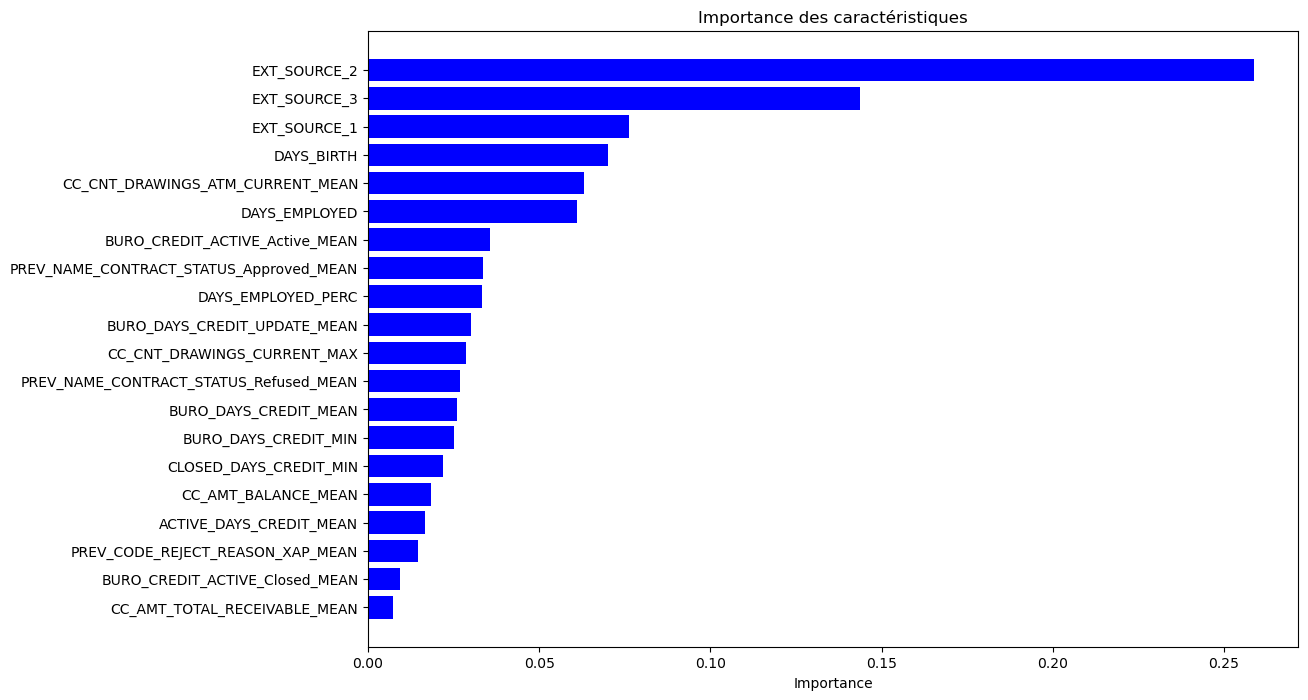

In [284]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

# Supposons que X_train, y_train sont déjà définis

# Création et ajustement du pipeline
gb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', GradientBoostingClassifier())
])

# Ajuster le pipeline aux données d'entraînement
gb_pipeline.fit(X_train, y_train)

# Extraire le modèle de Gradient Boosting du pipeline
gb_model = gb_pipeline.named_steps['classifier']

# Calculer l'importance des caractéristiques
feature_importance = gb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)

# Créer un DataFrame pour une meilleure visualisation
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns[sorted_idx],
    'Importance': feature_importance[sorted_idx]
})

# Visualiser l'importance des caractéristiques
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='blue')
plt.xlabel('Importance')
plt.title('Importance des caractéristiques')
plt.show()


Les caractéristiques liées aux sources externes, à l'âge, aux comportements financiers et aux historiques de crédit sont parmi les plus importantes pour le modèle. Cela souligne l'importance de ces facteurs dans la prédiction de la cible. Les caractéristiques provenant des données de bureau de crédit et des comportements de carte de crédit sont également très significatives, indiquant que l'historique de crédit et les comportements financiers jouent un rôle crucial dans les prédictions du modèle.

## <span style="color:green;">Local </span>

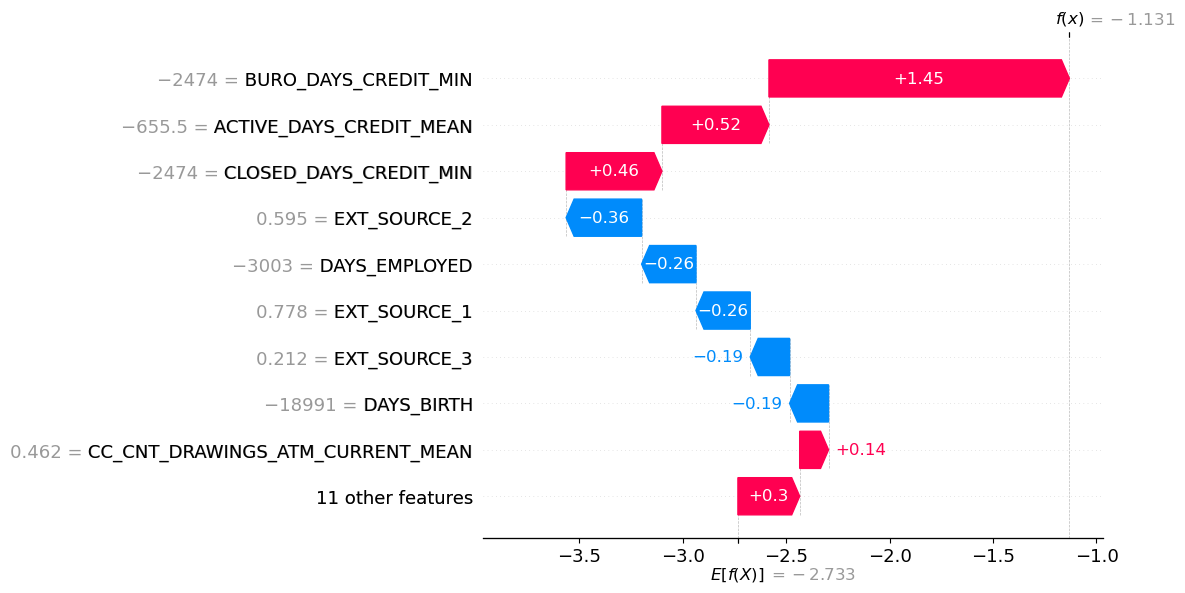

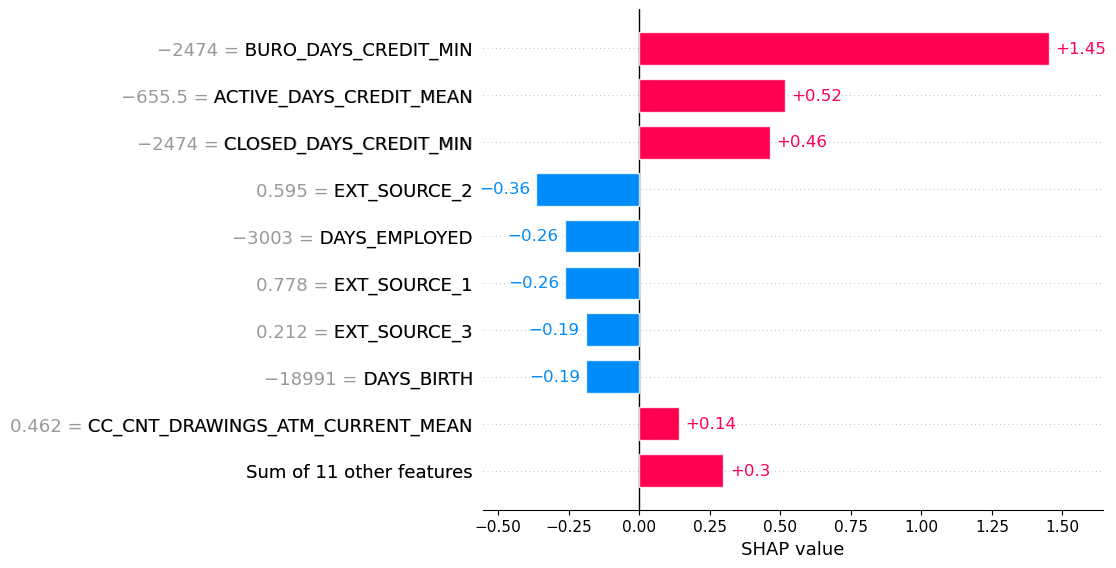

In [285]:
import shap
import matplotlib.pyplot as plt

# Extraire le modèle de Gradient Boosting du pipeline
gb_model = gb_pipeline.named_steps['classifier']

# Initialiser l'explainer SHAP avec le modèle
shap_explainer = shap.TreeExplainer(gb_model)

# Calculer les valeurs SHAP pour les données de test
shap_values = shap_explainer(X_test)

# Visualiser l'importance locale des caractéristiques pour une instance spécifique
idx = 0  # Index de l'instance spécifique
shap.initjs()

# Force plot
shap.plots.force(shap_values[idx])
plt.show()

# Waterfall plot
shap.plots.waterfall(shap_values[idx])
plt.show()

# Bar plot
shap.plots.bar(shap_values[idx])
plt.show()


Le graphique montre clairement quelles caractéristiques ont le plus grand impact sur la prédiction pour cette instance spécifique. Les caractéristiques comme BURO_DAYS_CREDIT_MIN et CLOSED_DAYS_CREDIT_MIN augmentent fortement la prédiction, tandis que des caractéristiques comme EXT_SOURCE_2 et DAYS_EMPLOYED la diminuent.

Ces informations peuvent être utilisées pour comprendre pourquoi le modèle a fait une certaine prédiction et pour identifier les domaines où des modifications peuvent être apportées pour influencer les résultats futurs.